In [1]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud,STOPWORDS
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image
import tensorflow as tf
import re
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from  tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Dense, LSTM, Embedding, Dropout, GRU
from sklearn.metrics import confusion_matrix,classification_report
import nltk
stopword = set(STOPWORDS)

from tensorflow.keras.layers import BatchNormalization
from keras import regularizers
from bs4 import BeautifulSoup
import re
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [2]:
wordcloud_mask=np.array(Image.open("/kaggle/input/wordcloud-mask-collection/batman.png"))

In [3]:
fake_data=pd.read_csv("/kaggle/input/fake-news-detection-datasets/News _dataset/Fake.csv")

In [4]:
fake_data.head(5)

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [5]:
real_data=pd.read_csv("/kaggle/input/fake-news-detection-datasets/News _dataset/True.csv")

In [6]:
real_data.head(5)

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [7]:
fake_data["subject"].value_counts()

subject
News               9050
politics           6841
left-news          4459
Government News    1570
US_News             783
Middle-east         778
Name: count, dtype: int64

In [8]:
real_data["subject"].value_counts()

subject
politicsNews    11272
worldnews       10145
Name: count, dtype: int64

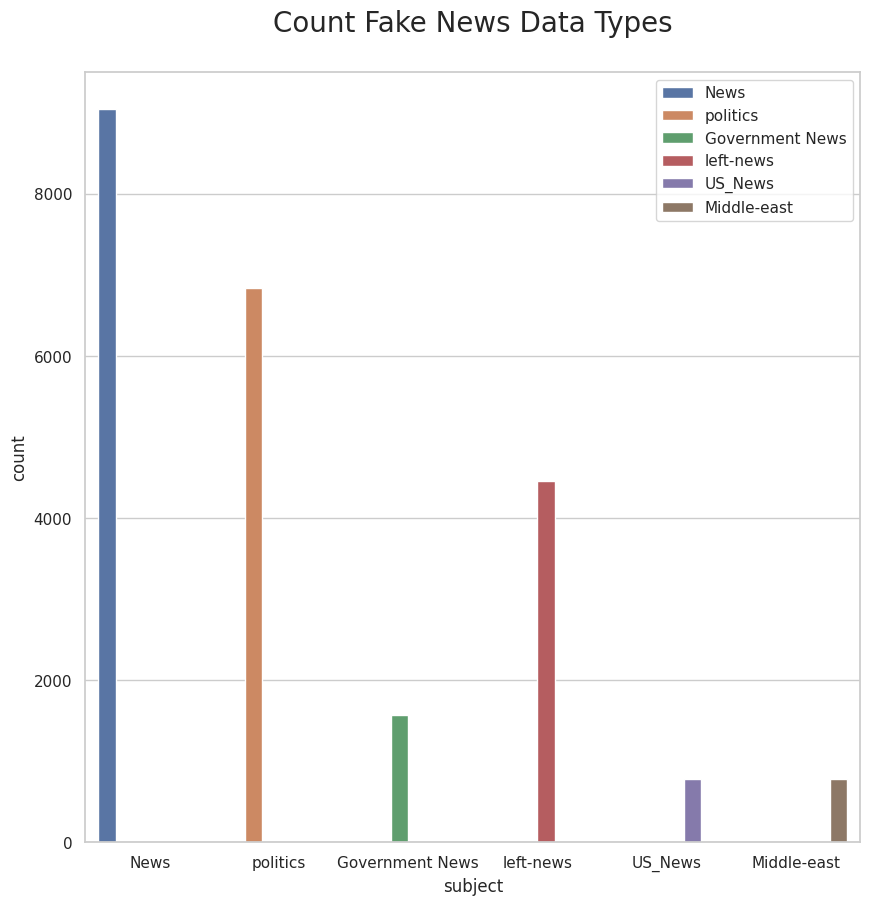

In [9]:
plt.figure(figsize=(10,10))
sns.set_theme(style="whitegrid")
sns.countplot(x="subject",data=fake_data,hue="subject")
plt.title("Count Fake News Data Types\n",fontsize=20)
plt.legend(loc="best")
plt.show()

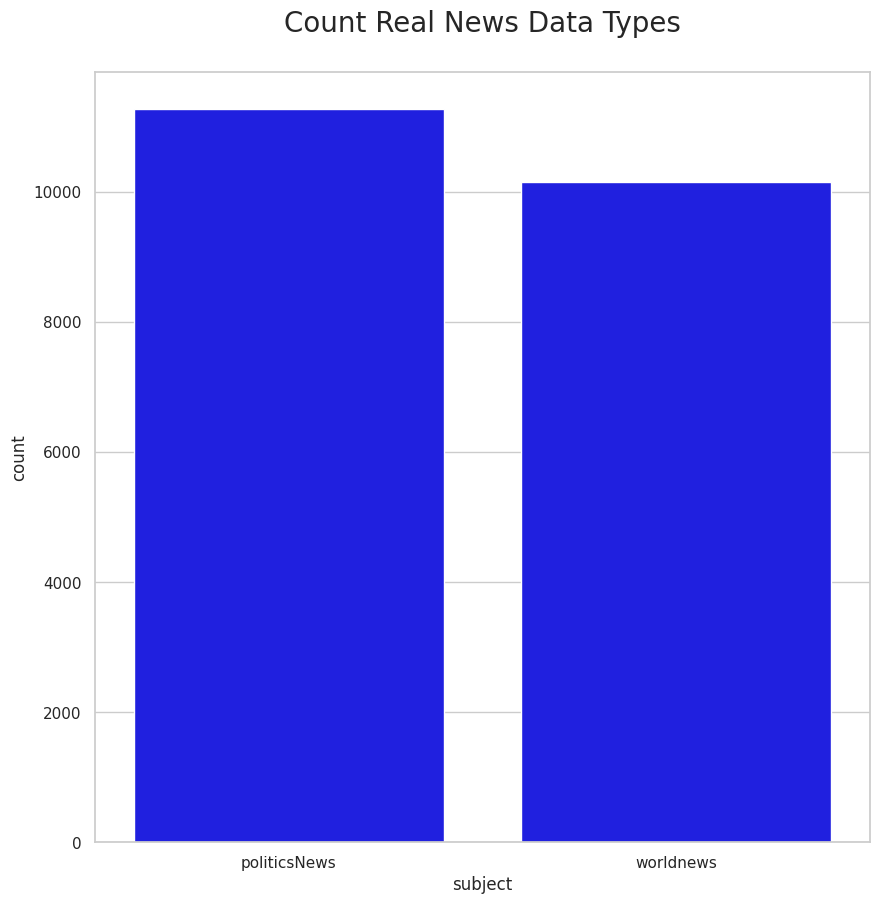

In [10]:
plt.figure(figsize=(10,10))
sns.countplot(x=real_data["subject"],color='blue')
plt.title("Count Real News Data Types\n",fontsize=20)
plt.show()

In [11]:
fake_text=" ".join(fake_data["text"].tolist())

# Fake Text Wordcloud

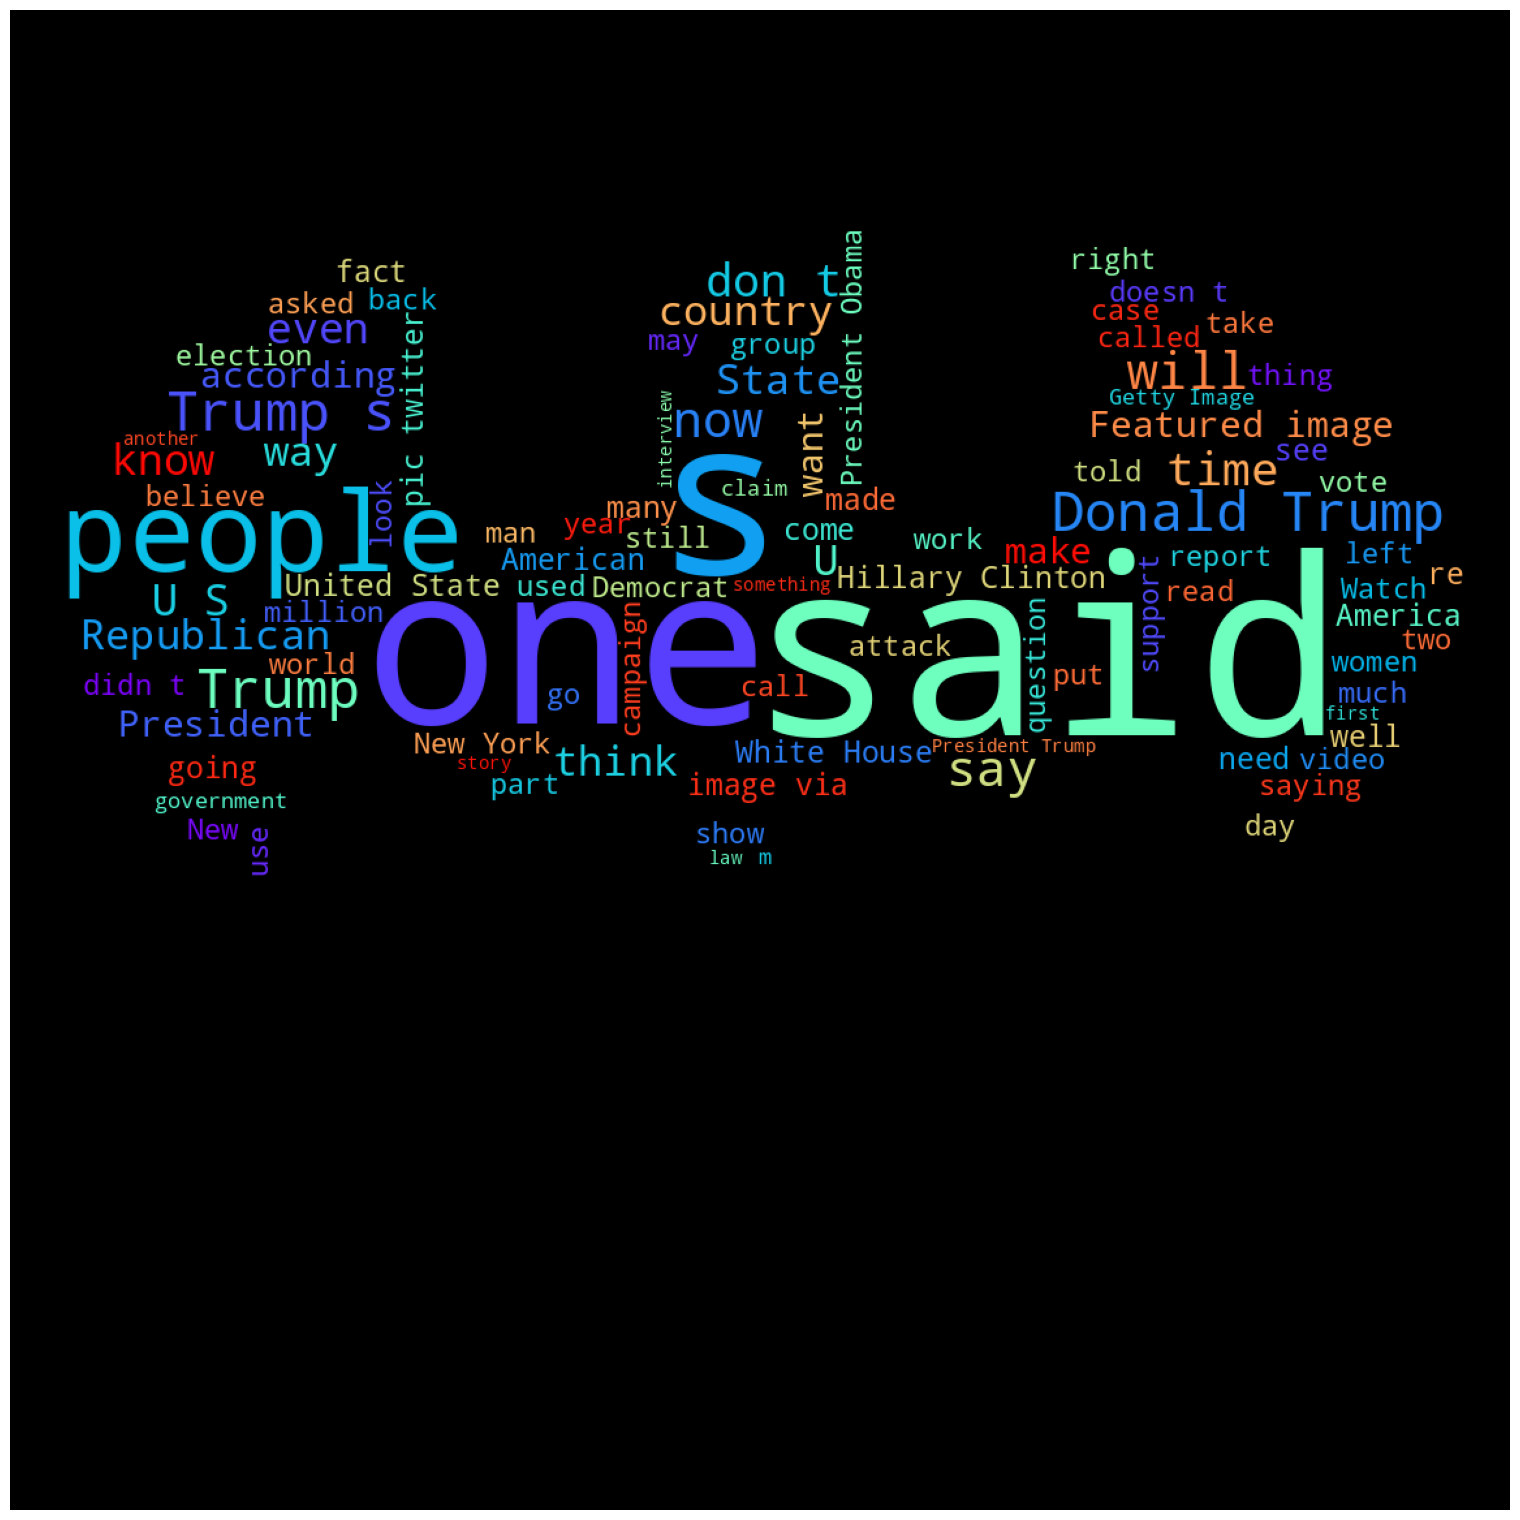

In [12]:
plt.figure(figsize=(15,15))
wordcloud=WordCloud(stopwords=stopword,width=1600,height=800,max_words=100,mask=wordcloud_mask,colormap='rainbow').generate(fake_text)

plt.axis("off")
plt.tight_layout(pad=0)
plt.imshow(wordcloud)
plt.show()

# Real Text Wordcloud

In [13]:
real_text=" ".join(real_data["text"].tolist())

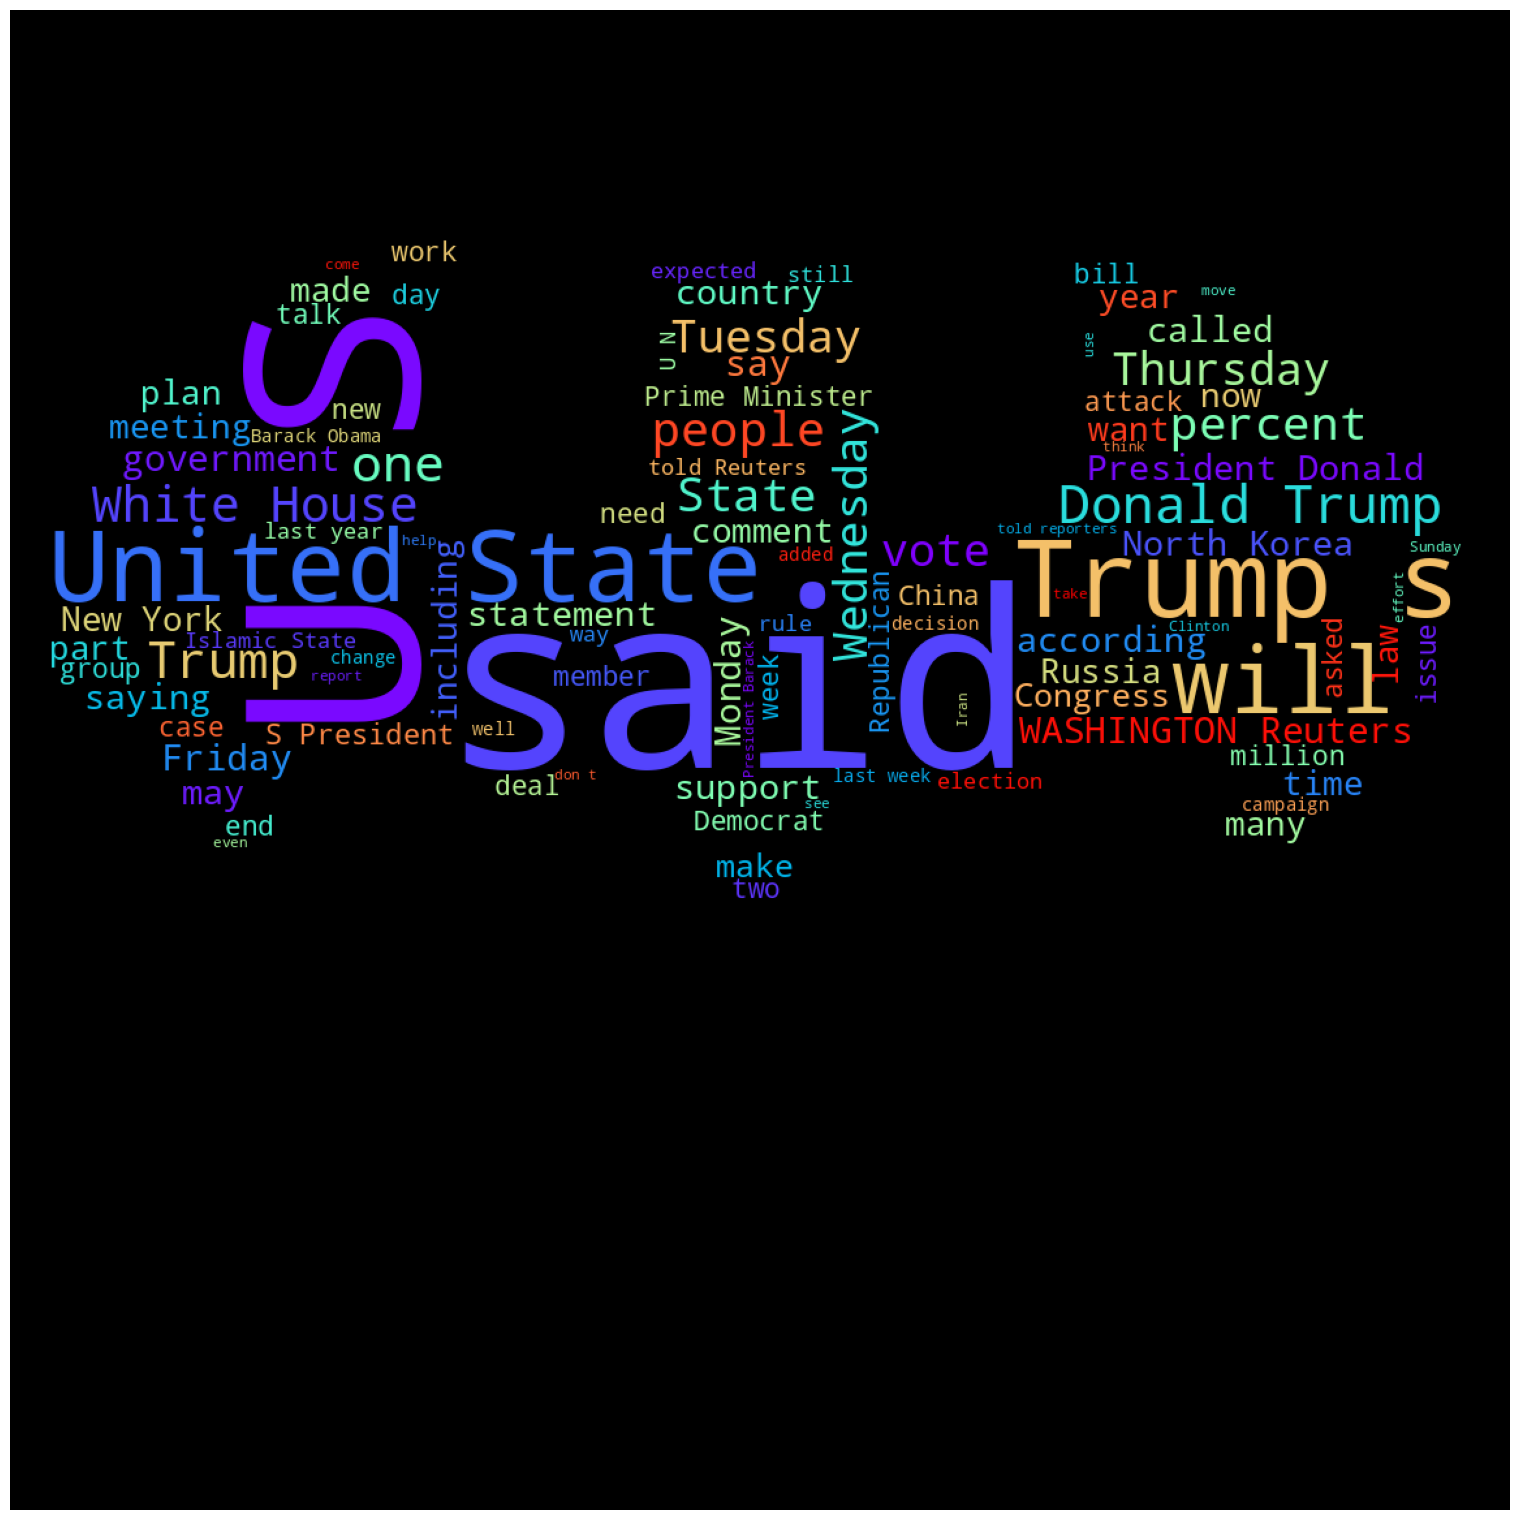

In [14]:
plt.figure(figsize=(15,15))
wordcloud=WordCloud(stopwords=stopword,width=1600,height=800,max_words=100,mask=wordcloud_mask,colormap='rainbow').generate(real_text)
plt.axis("off")
plt.tight_layout(pad=0)
plt.imshow(wordcloud)
plt.show()

In [15]:
unknown_publishers=[]
for index,row in enumerate(real_data.text.values):
   try:
     record=row.split("-",  maxsplit=1)
     record[1]
     
     assert(len(record[0])<120)
   except:
    unknown_publishers.append(index)

In [16]:
real_data.iloc[unknown_publishers].text

7        The following statements were posted to the ve...
8        The following statements were posted to the ve...
12       The following statements were posted to the ve...
13       The following statements were posted to the ve...
14        (In Dec. 25 story, in second paragraph, corre...
                               ...                        
20135     (Story corrects to million from billion in pa...
20500     (This Sept 8 story corrects headline, clarifi...
20667     (Story refiles to add dropped word  not , in ...
21246     (Story corrects third paragraph to show Mosul...
21339     (Story corrects to fix spelling in paragraph ...
Name: text, Length: 222, dtype: object

In [17]:
real_data=real_data.drop(8970,axis=0)

In [18]:
publisher=[]
temp_text=[]
for index,row in enumerate(real_data.text.values):
  if index in unknown_publishers:
    temp_text.append(row)
    publisher.append("unknow")
  else:
    record=row.split("-",maxsplit=1)
    publisher.append(record[0].strip())
    temp_text.append(record[1].strip())

In [19]:
real_data["publisher"]=publisher
real_data["text"]=temp_text

In [20]:
real_data.sample(5)

,title,text,subject,date,publisher
418,U.S. attorney general Sessions evasive on Russ...,U.S. Attorney General Jeff Sessions refused to...,politicsNews,"November 30, 2017",WASHINGTON (Reuters)
4904,Treasury's Mnuchin says Trump does not want tr...,U.S. Treasury Secretary Steven Mnuchin said on...,politicsNews,"March 16, 2017",BERLIN (Reuters)
17055,Malaysia in talks with U.S. firm Ocean Infinit...,Malaysia is negotiating with U.S.-based seabed...,worldnews,"October 19, 2017",KUALA LUMPUR (Reuters)
5129,Sessions to respond in writing to questions ov...,U.S. Attorney General Jeff Sessions will reply...,politicsNews,"March 3, 2017",WASHINGTON (Reuters)
5303,U.S. education secretary calls Obama transgend...,U.S. Education Secretary Betsy DeVos on Thursd...,politicsNews,"February 23, 2017",WASHINGTON (Reuters)


In [21]:
empty_fake_index=[index for index,text in enumerate(fake_data.text.tolist()) if str(text).strip()==""]

In [22]:
fake_data.iloc[empty_fake_index]

,title,text,subject,date
10923,TAKE OUR POLL: Who Do You Think President Trum...,,politics,"May 10, 2017"
11041,Joe Scarborough BERATES Mika Brzezinski Over “...,,politics,"Apr 26, 2017"
11190,WATCH TUCKER CARLSON Scorch Sanctuary City May...,,politics,"Apr 6, 2017"
11225,MAYOR OF SANCTUARY CITY: Trump Trying To Make ...,,politics,"Apr 2, 2017"
11236,SHOCKER: Public School Turns Computer Lab Into...,,politics,"Apr 1, 2017"
...,...,...,...,...
21816,BALTIMORE BURNS: MARYLAND GOVERNOR BRINGS IN N...,,left-news,"Apr 27, 2015"
21826,FULL VIDEO: THE BLOCKBUSTER INVESTIGATION INTO...,,left-news,"Apr 25, 2015"
21827,(VIDEO) HILLARY CLINTON: RELIGIOUS BELIEFS MUS...,,left-news,"Apr 25, 2015"
21857,(VIDEO)ICE PROTECTING OBAMA: WON’T RELEASE NAM...,,left-news,"Apr 14, 2015"


In [23]:
real_data["text"] =real_data["title"]+""+ real_data["text"]
fake_data["text"] =fake_data["title"]+""+ fake_data["text"]

In [24]:
real_data["text"]=real_data["text"].apply(lambda x:str(x).lower())
fake_data["text"]=fake_data["text"].apply(lambda x:str(x).lower())

In [25]:
real_data["label"]=1
fake_data["label"]=0

In [26]:
real_data=real_data[["text","label"]]

In [27]:
fake_data=fake_data[["text","label"]]

In [28]:
final_data = pd.concat([real_data, fake_data], ignore_index=True)

In [29]:
final_data.sample(5)

,text,label
41049,here’s how one man stopped huge riot ready to ...,0
31321,breaking: terror attack on london subway durin...,0
34764,why is loretta lynch opening for one of the bi...,0
42063,"long time democrats, union workers explain why...",0
29332,‘well-regulated’ militia member shoots 12-yea...,0


In [30]:
final_data.shape

(44897, 2)

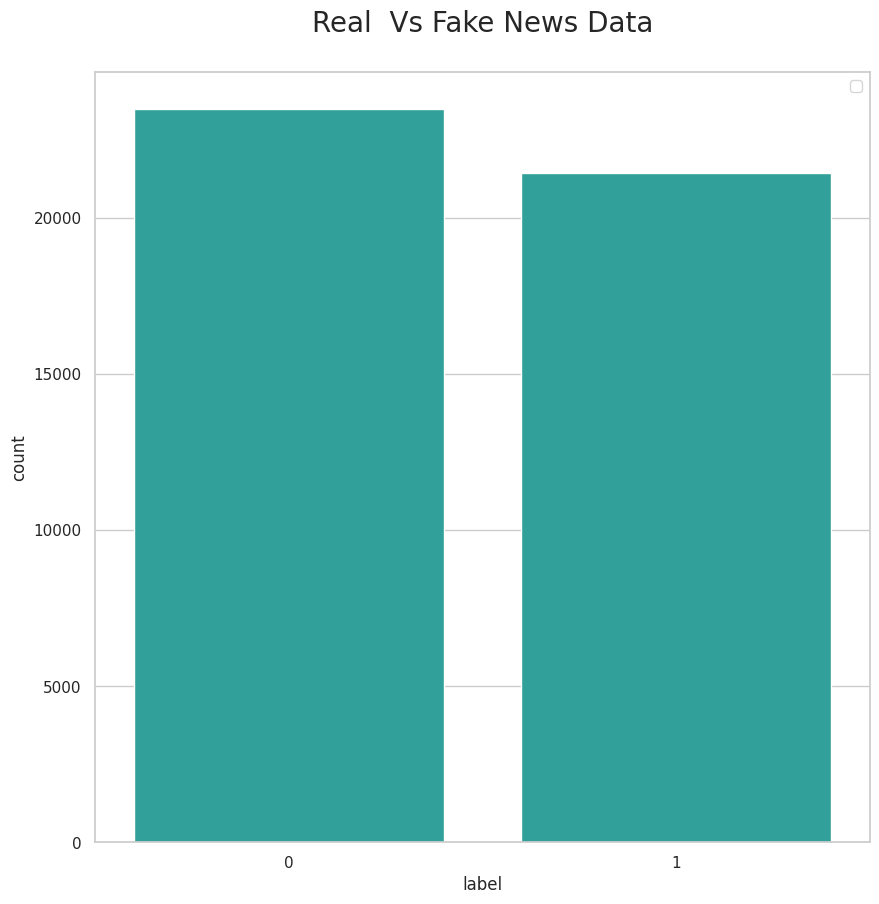

In [31]:
plt.figure(figsize=(10,10))
sns.countplot(x="label",data=final_data,color="lightseagreen")
plt.title("Real  Vs Fake News Data\n",fontsize=20)
plt.legend(loc="best")
plt.show()

In [32]:
from nltk.corpus import stopwords
import preprocess_kgptalkie as ps
stopwords=stopwords.words("english")
print(stopwords)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

# Data Cleaning

In [33]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
import string
from bs4 import BeautifulSoup

def clean_text(text):
    if isinstance(text, str):
        text = BeautifulSoup(text, 'html.parser').get_text()
        text = re.sub(r"[^a-zA-Z]", " ", text)
        text = text.translate(str.maketrans("", "", string.punctuation))

        emoji_pattern = re.compile("["
                                   u"\U0001F600-\U0001F64F"
                                   u"\U0001F300-\U0001F5FF"
                                   u"\U0001F680-\U0001F6FF"
                                   u"\U0001F1E0-\U0001F1FF"
                                   u"\U00002702-\U000027B0"
                                   u"\U000024C2-\U0001F251"
                                   "]+", flags=re.UNICODE)
        text = emoji_pattern.sub(r'', text)

        text = re.sub(r"#.*", "", text)
        text = re.sub(r"/\*.*?\*/", "", text, flags=re.DOTALL)
        text = text.lower()

       
        nltk_stop_words = set(stopwords.words('english'))
        tokens = word_tokenize(text)
        tokens = [word for word in tokens if word not in nltk_stop_words]

        text = ' '.join(tokens)

        return text
    else:
        return ""


In [34]:
final_data["text"]=final_data["text"].apply(clean_text)

/opt/conda/lib/python3.10/site-packages/bs4/__init__.py:414: MarkupResemblesLocatorWarning: "https://100percentfedup.com/video-hillary-asked-about-trump-i-just-want-to-eat-some-pie/https://100percentfedup.com/video-hillary-asked-about-trump-i-just-want-to-eat-some-pie/" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/bs4/__init__.py:414: MarkupResemblesLocatorWarning: "https://fedup.wpengine.com/wp-content/uploads/2015/04/hillarystreetart.jpghttps://fedup.wpengine.com/wp-content/uploads/2015/04/hillarystreetart.jpg" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/bs4/__init__.py:414: MarkupResemblesLo

In [35]:
text_data=final_data["text"].copy()

In [36]:
label_data=final_data["label"].values


In [37]:
corpus = []
for i in range(0, len(text_data)):
    review = text_data[i]
    review = review.split()
    review = ' '.join(review)
    corpus.append(review)

In [38]:

embedding_dim=100

In [39]:
vocab_size = 20000
onehot_encoding=[one_hot(words,vocab_size)for words in corpus] 

In [40]:
max_len=1000
embedded_docs=pad_sequences(onehot_encoding,maxlen=max_len,padding='pre')

In [41]:
X_data=np.array(embedded_docs)
Y_label=np.array(label_data)

In [42]:
X_train,X_test, Y_train,Y_test = train_test_split(X_data,Y_label, test_size=0.3, random_state=42,shuffle=True)

# Create GRU Model

In [43]:
model=Sequential()
model.add(Embedding(vocab_size,embedding_dim,input_shape=(max_len,),trainable=False))
model.add(BatchNormalization())
model.add(GRU(units=128,activation="tanh",kernel_regularizer=regularizers.l2(0.0001)))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Dense(1,activation="sigmoid"))
model.compile(optimizer="adam",loss="binary_crossentropy",metrics=["accuracy"])
model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 1000, 100)      │     2,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1000, 100)      │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 128)            │        88,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,089,873 (7.97 MB)

 Trainable params: 89,161 (348.29 KB)

 Non-trainable params: 2,000,712 (7.63 MB)

In [44]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', mode='min', verbose=1,patience=50)

In [45]:
history=model.fit(X_train,Y_train,validation_data=(X_test,Y_test),epochs=10,batch_size=42,callbacks=[callback])

Epoch 1/10
749/749 ━━━━━━━━━━━━━━━━━━━━ 48s 59ms/step - accuracy: 0.8569 - loss: 0.3233 - val_accuracy: 0.9660 - val_loss: 0.1070
Epoch 2/10
749/749 ━━━━━━━━━━━━━━━━━━━━ 44s 58ms/step - accuracy: 0.9780 - loss: 0.0748 - val_accuracy: 0.9388 - val_loss: 0.1705
Epoch 3/10
749/749 ━━━━━━━━━━━━━━━━━━━━ 44s 58ms/step - accuracy: 0.9900 - loss: 0.0463 - val_accuracy: 0.9860 - val_loss: 0.0581
Epoch 4/10
749/749 ━━━━━━━━━━━━━━━━━━━━ 44s 58ms/step - accuracy: 0.9928 - loss: 0.0368 - val_accuracy: 0.9932 - val_loss: 0.0358
Epoch 5/10
749/749 ━━━━━━━━━━━━━━━━━━━━ 43s 58ms/step - accuracy: 0.9945 - loss: 0.0318 - val_accuracy: 0.9690 - val_loss: 0.1149
Epoch 6/10
749/749 ━━━━━━━━━━━━━━━━━━━━ 43s 58ms/step - accuracy: 0.9944 - loss: 0.0328 - val_accuracy: 0.9823 - val_loss: 0.0763
Epoch 7/10
749/749 ━━━━━━━━━━━━━━━━━━━━ 43s 58ms/step - accuracy: 0.9955 - loss: 0.0280 - val_accuracy: 0.9883 - val_loss: 0.0558
Epoch 8/10
749/749 ━━━━━━━━━━━━━━━━━━━━ 43s 58ms/step - accuracy: 0.9970 - loss: 0.0260 - 

In [46]:
def model_loss_and_accuracy(history):
    
    fig=plt.figure(figsize=(10,10))
    plt.subplot(221)
    plt.plot(history.history["accuracy"],"b*--",label="accuracy")
    plt.plot(history.history["val_accuracy"],"r*--",label="val_accuracy")
    plt.title("Model Accuracy")
    plt.xlabel("Number of Epochs")
    plt.ylabel("Accuracy")
    plt.grid(color = 'green', linestyle = '--', linewidth = 1)
    plt.legend(loc="best")
    plt.tight_layout()
    
  
    plt.subplot(222)
    plt.plot(history.history["loss"],"b*--",label="loss")
    plt.plot(history.history["val_loss"],"r*--",label="val_loss")
    plt.title("Model Loss")
    plt.xlabel("Number of Epochs")
    plt.ylabel("Loss")
    plt.grid(color = 'green', linestyle = '--', linewidth = 1)
    plt.legend(loc="best")
    plt.tight_layout()
    plt.show()

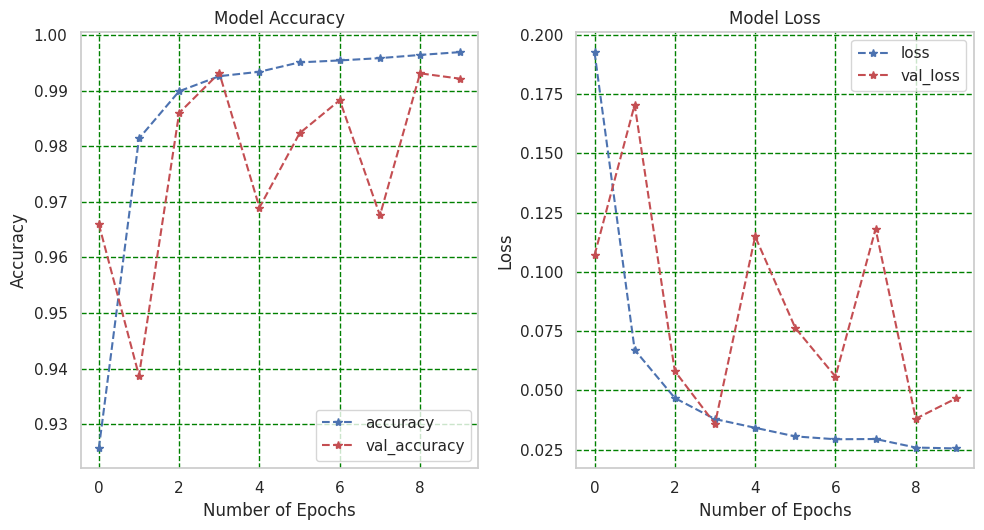

In [47]:
 model_loss_and_accuracy(history)

In [48]:
class_name=["Fake","Real"]

In [49]:
predict_label=(model.predict(X_test) > 0.5).astype("int32")
confusion_matrix = confusion_matrix(Y_test,predict_label)

421/421 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step


In [50]:
confusion_matrix_label = ["True Negative","False Negative","False Positive","True Positive"]
confusion_matrix_value_counts = ["{0:0.0f}".format(value) for value in confusion_matrix.flatten()]
confusion_matrix_value_percentage= ["{0:.2%}".format(value) for value in confusion_matrix.flatten()/np.sum(confusion_matrix)]
confusion_matrix_labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(confusion_matrix_label,confusion_matrix_value_counts ,confusion_matrix_value_percentage)]
confusion_matrix_labels = np.asarray(confusion_matrix_labels).reshape(2,2)

# Confusion Matrix

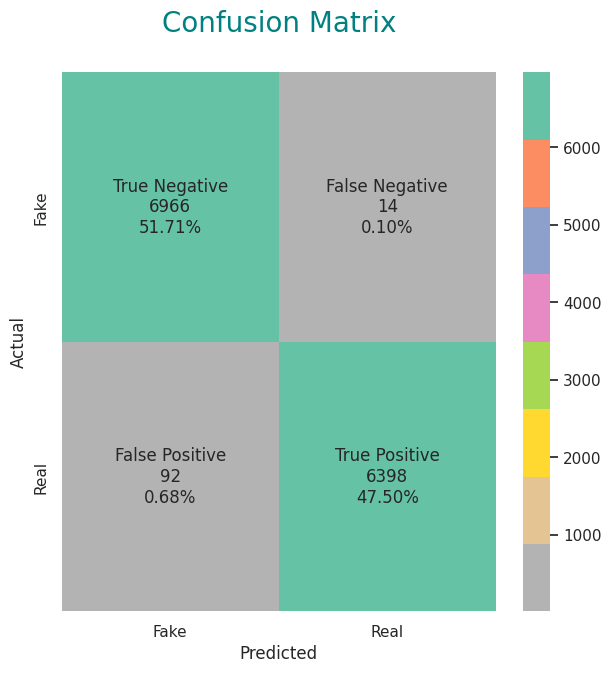

In [51]:
plt.figure(figsize=(7,7))
sns.heatmap(confusion_matrix, annot=confusion_matrix_labels, fmt="", cmap='Set2_r',xticklabels=class_name,yticklabels=class_name)
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.title("Confusion Matrix\n",fontsize=20,color="teal")
plt.show()

# Classification Report

In [52]:
print(classification_report(Y_test,predict_label,target_names=["Fake","Real"]))

              precision    recall  f1-score   support

        Fake       0.99      1.00      0.99      6980
        Real       1.00      0.99      0.99      6490

    accuracy                           0.99     13470
   macro avg       0.99      0.99      0.99     13470
weighted avg       0.99      0.99      0.99     13470



# Custom Data Prediction

In [53]:
custom_data="Iran's leaders have portrayed the anti-government protests as  instigated by foreign enemies"

In [54]:
test_data= []
for i in range(0, len(custom_data)):
    review =custom_data[i]
    review = review.split()
    review = ' '.join(review)
    test_data.append(review)

In [55]:
voc_size = 100
onehot_repr=[one_hot(words,voc_size)for words in test_data]
sent_length=20
embedded_docs=pad_sequences(onehot_repr,maxlen=sent_length,padding='pre')
test_data=np.array(embedded_docs)

In [56]:
prediction=(model.predict(test_data)>0.5).astype(int)

if(prediction[0]==0):
  print("News is Fake")
else:
  print("News is Real")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  
News is Fake
